In [ ]:
# Set locale to UTF-8
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# !pip install -U spacy[cuda] cupy-cuda113 torch torchvision torchaudio

In [ ]:
# !pip install -U spacy
# !pip install -U spacy[cuda]
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [ ]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
import re
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# pd.set_option('display.max_rows', 15)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [ ]:
# Ensure CuPy is available
try:
    import cupy
    spacy.require_gpu()
    print("CuPy is installed and GPU is available for SpaCy.")
except ImportError:
    print("CuPy is not installed. Install CuPy for GPU support with SpaCy.")

CuPy is not installed. Install CuPy for GPU support with SpaCy.


In [ ]:
# spacy.require_gpu()
spacy.prefer_gpu()

False

In [ ]:
def check_gpu_status():
    if torch.cuda.is_available():
        print("GPU is available")
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total,memory.used,memory.free --format=csv,noheader
        for info in gpu_info:
            print(info)
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024 ** 3:.2f} GB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024 ** 3:.2f} GB")
    else:
        print("GPU is not available")

check_gpu_status()

GPU is not available


In [ ]:
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Read and Preprocess the Data**

### 1.1. Read the Data

In [ ]:
# Read the dataset
file_path = '/content/drive/MyDrive/Datasets/nlp/IMDB Dataset.csv'
df = pd.read_csv(file_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


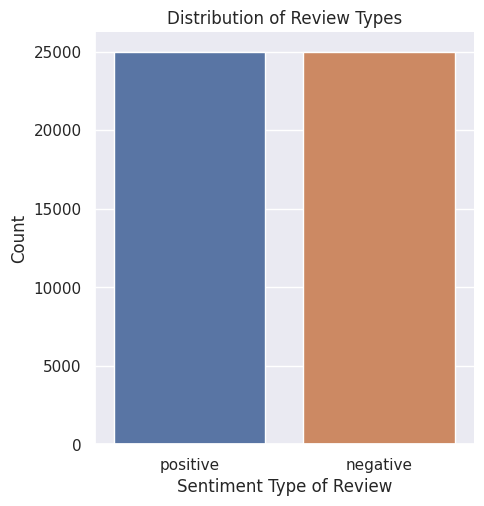

In [ ]:
# Visualize distribution of target
sns.catplot(x='sentiment', hue='sentiment', kind='count', data=df, legend=False)
plt.title('Distribution of Review Types')
plt.xlabel('Sentiment Type of Review')
plt.ylabel('Count');

In [ ]:
# Review full text of the first three reviews
df['review'][:3]

,review
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side."
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends."


### 1.2. Decreasing Size of Dataset and Cleanup the Memory

**I initialized GPU support for spaCy in Google Colab, but could not get increased speed of processing data. So I have reduced the size of the dataset to 10K because spaCy is processing the original dataset of 50K without GPU very long time.**


In [ ]:
df_small = df[:10000].copy()

In [ ]:
# Remove initial dataset from the memory
import gc

# Display the memory usage before deleting the dataset
print(f"Memory usage before deletion: {df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

# Delete the DataFrame
del df

# Run garbage collection
gc.collect()

# Verify that the DataFrame has been deleted
try:
    print(df)
except NameError:
    print("DataFrame has been deleted.")

Memory usage before deletion: 77.77 MB
DataFrame has been deleted.


### 1.3. Text Cleaning

#### Text Preprocess & Clean may include:

1. Removing noise (e.g., HTML tags, special characters)
2. Normalizing case
3. Correcting spelling errors
4. Tokenizing text into words or sentences
5. Removing stop words
6. Stripping punctuation
7. Lemmatization
8. Stemming


In [ ]:
nlp = spacy.load("en_core_web_sm")

**We will define a few different functions for clean up the text.
We will choose later certain functions that would be applied.
Most of them use Token Class from spaCy**

In [ ]:
# Remove punctuations and lower text (with spaCy)
def lower_text(text: str):
  '''
  This function removes all punctuations
  and lower the text
  '''
  doc = nlp(text)
  tokens = [token.lower_ for token in doc if not token.is_punct]
  return " ".join(tokens)

In [ ]:
def remove_urls(text: str):
  '''
  This function removes all tokens
  like urls
  '''
  doc = nlp(text)
  tokens = [token.lower_ for token in doc if not token.like_url]
  return " ".join(tokens)

In [ ]:
def remove_digits(text):
    '''
    This function removes all digits
    '''
    doc = nlp(text)
    tokens = [token.lower_ for token in doc if not token.is_digit]
    return " ".join(tokens)

In [ ]:
def remove_special_characters(text: str, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, ' ', text)
    return text

In [ ]:
def remove_between_square_brackets(text):
    '''
    Removing the square brackets and its content
    '''
    return re.sub('\[[^]]*\]', '', text)

In [ ]:
def remove_html_tags(text):
    '''
    Removing HTML tags
    '''
    pattern = re.compile("<.*?>")
    return pattern.sub(r"", text)

In [ ]:
# Preprocess text
def preprocess_and_lemmatize(text: str):
    '''
    This function lemmatize all tokens that
    are not stopwords, like urls, digits
    '''
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not
              token.is_stop and not
              token.like_url and not
              token.is_digit]
    return " ".join(tokens)


def preprocess_and_lemmatize_gpu(texts):
    '''
    Lematization of all tokens that are not
    stopwords, like urls, digits with batches
    - optimized for GPU
    '''
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=50, n_process=-1), total=len(texts)):
        tokens = [token.lemma_ for token in doc if not
              token.is_stop and not
              token.like_url and not
              token.is_digit]
        # check_gpu_status()
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

In [ ]:
df_small['cleaned_review'] = df_small['review'].progress_apply(remove_html_tags)

100%|██████████| 10000/10000 [00:00<00:00, 108050.21it/s]


In [ ]:
df_small['cleaned_review'] = df_small['cleaned_review'].progress_apply(remove_special_characters)

100%|██████████| 10000/10000 [00:00<00:00, 27762.27it/s]


In [ ]:
# Remove stopwords, digits, like_urls and lematize text
df_small['cleaned_review'] = df_small['cleaned_review'].progress_apply(preprocess_and_lemmatize)

100%|██████████| 10000/10000 [10:56<00:00, 15.22it/s]


In [ ]:
# Optimized for use spaCy with GPU - no speed up
# df_small['cleaned_review'] = preprocess_and_lemmatize_gpu(df_small['cleaned_review'].tolist())

In [ ]:
# df_small['cleaned_review'] = df_small['cleaned_review'].progress_apply(lower_text)
# df['cleaned_review'] = df['review'].progress_apply(remove_punctuations)
# df['cleaned_review'] = df['cleaned_review'][:100].apply(remove_digits)
# df['cleaned_review'] = df['cleaned_review'][:100].apply(remove_brackets)
# df['cleaned_review'] = df['cleaned_review'][:100].apply(remove_urls)
# df['cleaned_review'] = df['review'].apply(remove_between_square_brackets)
# df['cleaned_review'] = df['cleaned_review'].progress_apply(lemmatize_and_stopwords)

In [ ]:
df_small['cleaned_review'][:3]

,cleaned_review
0,reviewer mention watch oz episode ll hook right exactly happen thing strike Oz brutality unflinche scene violence set right word trust faint hearted timid pull punch regard drug sex violence hardcore classic use word call OZ nickname give Oswald Maximum Security State Penitentary focus mainly Emerald City experimental section prison cell glass front face inward privacy high agenda Em City home Aryans Muslims gangsta Latinos Christians Italians irish scuffle death stare dodgy dealing shady agreement far away main appeal fact go show wouldn t dare forget pretty picture paint mainstream audience forget charm forget romance OZ doesn t mess episode see strike nasty surreal couldn t ready watch develop taste Oz get accustomed high level graphic violence violence injustice crooked guard ll sell nickel inmate ll kill order away mannered middle class inmate turn prison bitch lack street skill prison experience Watching Oz comfortable uncomfortable viewing s touch dark
1,wonderful little production film technique unassuming old time BBC fashion give comforting discomforte sense realism entire piece actor extremely choose Michael Sheen get polari voice pat truly seamless editing guide reference Williams diary entry worth watching terrificly write perform piece masterful production great master s comedy life realism come home little thing fantasy guard use traditional dream technique remain solid disappear play knowledge sense particularly scene concern Orton Halliwell set particularly flat Halliwell s mural decorate surface terribly
2,think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable bread suspect serial killer disappoint realize Match Point Risk Addiction think proof Woody Allen fully control style grow love d laugh Woody s comedy year dare decade ve impressed Scarlet Johanson manage tone sexy image jump right average spirited young woman crown jewel career witty Devil Wears Prada interesting Superman great comedy friend


## **2. Classification Model Training**

In [ ]:
# Feature extraction using TF-IDF Vectorizer
# vectorizer = TfidfVectorizer(max_features=10000)    # Limited with 10000 tokens (total number of tokens = 92K)
vectorizer = TfidfVectorizer()    # We will use all tokens

X = vectorizer.fit_transform(df_small['cleaned_review']).toarray()
y = df_small['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
X.shape

(10000, 44089)

**Original dataset had 92K tokens**

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Report: \n{report}")

Accuracy: 0.8525
Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       996
           1       0.85      0.85      0.85      1004

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

